In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from random import shuffle
from tqdm import tqdm
import os

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [10]:
def extractImages(pathIn, pathOut):
    count = 0
    vidcap = cv.VideoCapture(pathIn)
    success,image = vidcap.read()
    success = True
    print(success)
    while success:
      vidcap.set(cv.CAP_PROP_POS_MSEC,(count*1000))    # added this line 
      success,image = vidcap.read()         
      cv.imwrite( pathOut + "/frame%d.jpg" % count, image)     # save frame as JPEG file
      count = count + 1

In [11]:
w = 96
h = 96

In [12]:
def list_dir(path):
    fileNames = []
    for root, dirs, files in os.walk(path):  
        for filename in tqdm(files): 
            fileNames.append(filename)            
    return fileNames

In [13]:
files = list_dir('../videos')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<?, ?it/s]


In [14]:
print(files[0])

night-1.mp4


In [15]:
def extract(videoRoot, imageRoot):
    videos = list_dir(videoRoot)
    for video in tqdm(videos):
        videoPath = videoRoot + '/' + video
        videoName = video.split('.')[0]
        imagePath = imageRoot+'/' +videoName
        if not os.path.exists(imagePath):
            os.makedirs(imagePath)
            extractImages(videoPath,imagePath)        

In [17]:
extract('../videos', '../images')

  0%|                                                                                                                                      | 0/8 [00:00<?, ?it/s]

True


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.17s/it]


In [43]:

def read_labels(lablesFile):
    labelData = []
    with open(lablesFile) as inf:
        for line in tqdm(inf):            
            video, frame, label, clazz = line.strip().split(",")
            frame = int(frame)
            label = int(label)
            labelData.append({'video':video, 'frame':frame, 'label':label, 'class':clazz})
    return labelData

labels = read_labels('../labels/labels.csv')
labels2 = read_labels('../labels/labels2.csv')

            

264it [00:00, 263391.12it/s]
330it [00:00, 165011.96it/s]


In [33]:
def pre_process(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    lower = np.array([49,89,127])
    upper = np.array([179,225,255])
    []
    mask = cv.inRange(hsv, lower, upper)
    result = cv.bitwise_and(hsv, hsv, mask=mask)
    result_gray = cv.cvtColor(result, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(result_gray, 7, 255, cv.THRESH_BINARY)
    resized = cv.resize(thresh, (96,96))    
    #cropped = resized[0:72, 0:96]
    return resized

In [12]:
def get_label(file, labels):    
    for l in labels:         
        if 'frame' + str(l['frame']) + '.jpg' == file:
            if l['class'] == 'Light':                
                return np.array([1,0])
            else:
                return np.array([0,1])
    return np.array([1,1])
    
def train_data_with_label(train_data, labels):
    train_images = []    
    for i in tqdm(os.listdir(train_data)):        
        path = os.path.join(train_data, i)        
        img = cv.imread(path)
        img = pre_process(img)     
        label = get_label(i, labels)      
        train_images.append([np.array(img),label])              
    #shuffle(train_images)
    return train_images

(96, 96)
(96, 96)


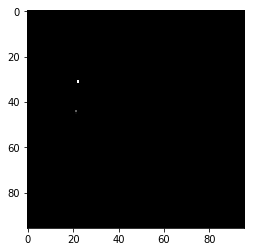

In [34]:
varimg_gray = cv.imread('../images/video-x/frame24.jpg', cv.IMREAD_GRAYSCALE)
varimg_gray = cv.resize(varimg_gray, (w,h)) 
varimg = cv.imread('../images/video-x/frame24.jpg')

processed = pre_process(varimg)
plt.imshow(processed, cmap='gray')
print(varimg_gray.shape)
print(processed.shape)

In [35]:
train_data = train_data_with_label('../images/video-2', labels)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 30.48it/s]


In [23]:
len(train_data)

31

In [24]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *

Using TensorFlow backend.


In [44]:
test_data = train_data_with_label('../images/video-1', labels2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:08<00:00, 30.89it/s]


In [45]:
tr_img_data = np.array([i[0] for i in train_data]).reshape(-1, w,h,1)
tr_lbl_data = np.array([i[1] for i in train_data])

tst_img_data = np.array([i[0] for i in test_data]).reshape(-1, w,h,1)
tst_lbl_data = np.array([i[1] for i in test_data])


In [38]:
model = Sequential()

model.add(InputLayer(input_shape=[w,h,1]))
model.add(Conv2D(filters=32, kernel_size=5,strides=1,padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=5,padding='same'))

model.add(Conv2D(filters=50,kernel_size=5,strides=1,padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=5,padding='same'))

model.add(Conv2D(filters=80,kernel_size=5,strides=1,padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=5,padding='same'))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(2,activation='softmax'))
optimizer = Adam(lr=1e-3)

model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x=tr_img_data,y=tr_lbl_data,epochs=50,batch_size=10)
model.summary()

Epoch 1/50
31/31 [==============================] - ETA: 1s - loss: 0.7496 - acc: 0.200 - ETA: 0s - loss: 0.9635 - acc: 0.400 - ETA: 0s - loss: 0.8274 - acc: 0.566 - 1s 31ms/step - loss: 0.8226 - acc: 0.5806
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.6391 - acc: 0.800 - ETA: 0s - loss: 0.7028 - acc: 0.850 - ETA: 0s - loss: 0.7492 - acc: 0.766 - 0s 13ms/step - loss: 0.9449 - acc: 0.7419
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.9619 - acc: 0.800 - ETA: 0s - loss: 0.8103 - acc: 0.700 - ETA: 0s - loss: 0.7201 - acc: 0.766 - 0s 14ms/step - loss: 0.7191 - acc: 0.7742
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 1.8033 - acc: 0.900 - ETA: 0s - loss: 1.1340 - acc: 0.850 - ETA: 0s - loss: 0.9520 - acc: 0.833 - 0s 13ms/step - loss: 0.9406 - acc: 0.8387
Epoch 5/50
31/31 [==============================] - ETA: 0s - loss: 0.5774 - acc: 0.800 - ETA: 0s - loss: 0.6701 - acc: 0.800 - ETA: 0s - loss: 0.6047 - acc: 0.766 - 0s

In [39]:
    test_img = train_data[26][0]
    predict_data = test_img.reshape(-1,w,h,1)
    model_out = model.predict([predict_data])
    print(model_out)

[[5.3164436e-05 9.9994683e-01]]


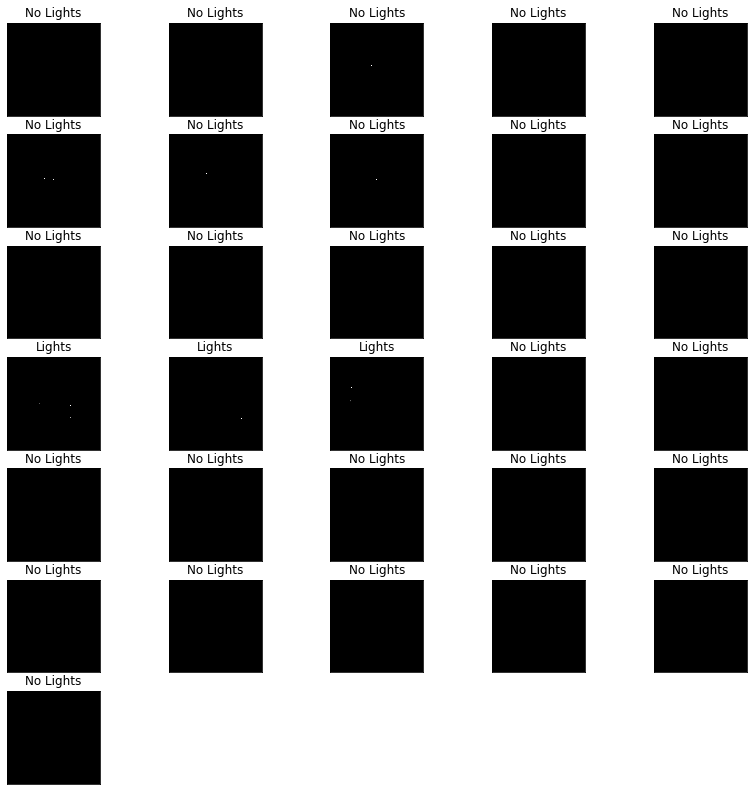

In [41]:
fig =plt.figure(figsize=(14,14))
plot_cols = 5
plot_rows = len(train_data)/plot_cols+1
for cnt, data in enumerate(train_data[:]):
    y = fig.add_subplot(plot_rows,plot_cols, cnt+1)
    img = data[0]
    data = img.reshape(1,w,h,1)
    model_out = model.predict([data])
    
    if np.argmax(model_out) == 1:
        str_label = 'No Lights'
    else:
        str_label = 'Lights'
        
    y.imshow(img, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)    

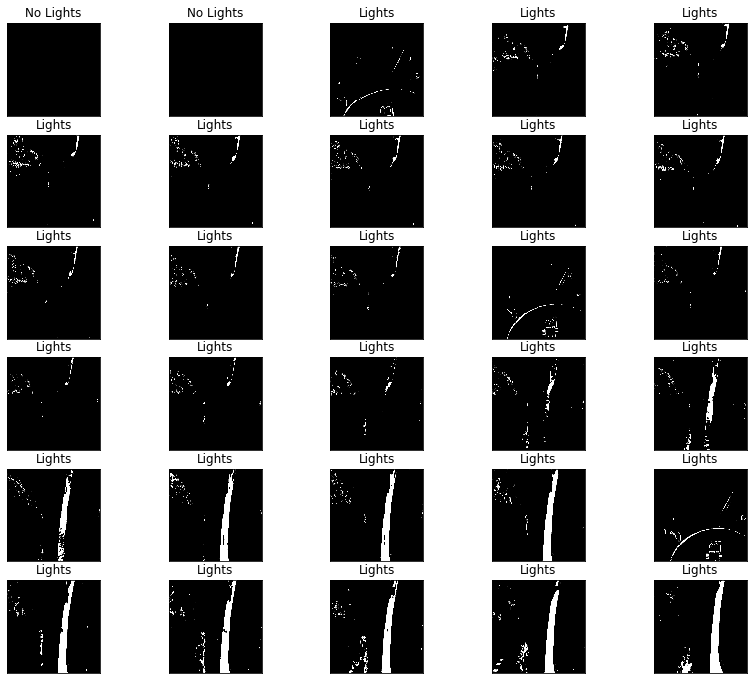

In [47]:
fig =plt.figure(figsize=(14,14))
plot_cols = 5
plot_rows = 30/plot_cols+1
for cnt, data in enumerate(test_data[:30]):
    y = fig.add_subplot(plot_rows,plot_cols, cnt+1)
    img = data[0]
    data = img.reshape(1,w,h,1)
    model_out = model.predict([data])
    
    if np.argmax(model_out) == 1:
        str_label = 'No Lights'
    else:
        str_label = 'Lights'
        
    y.imshow(img, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)    